# ТЕЛЕКОМ

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать 
отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут 
предложены промокоды и специальные условия. Команда оператора 
собрала персональные данные о некоторых клиентах, информацию об их 
тарифах и договорах. 

**Цель проекта:**

Создать модель машинного обучения для прогнозирования оттока клиентов, чтобы удержать клиентов с помощью предложения им специальных условий. 

**Задачи проекта:**

1. Исследовательский анализ данных
2. Предобработка данных
3. Создание и поиск лучшей модели для прогнозирования оттока клиентов
4. Проверка лучшей модели на тестовой выборке
5. Создание отчета по результатам проекта

**Описание услуг**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

**Обозначение признаков**

- `BeginDate` – дата начала пользования услугами,
- `EndDate` – дата окончания пользования услугами,
- `Type` – тип оплаты: ежемесячный, годовой и тд,
- `PaperlessBilling` – безналичный расчет,
- `PaymentMethod` – способ оплаты,
- `MonthlyCharges` – ежемесячные траты на услуги,
- `TotalCharges` – всего потрачено денег на услуги
- `Dependents` – наличие иждивенцев
- `Senior Citizen` – наличие пенсионного статуса по возрасту
- `Partner` – наличие супруга(и)
- `MultipleLines` – наличие возможности ведения параллельных линий во время звонка

# Исследовательский анализ данных

## Подготовка данных

Импортирую библиотеки и подгружаю таблицы, индексом таблиц задам уникальный код клиентов.

In [1]:
!pip install phik

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [3]:
try:
    
    df_contract = pd.read_csv('Final_project/contract_new.csv', index_col='customerID', parse_dates=[1])
    df_personal = pd.read_csv('Final_project/personal_new.csv', index_col='customerID')
    df_internet = pd.read_csv('Final_project/internet_new.csv', index_col='customerID')
    df_phone = pd.read_csv('Final_project/phone_new.csv', index_col='customerID')
    
except:
    
    df_contract = pd.read_csv('/datasets/contract_new.csv', index_col='customerID', parse_dates=[1])
    df_personal = pd.read_csv('/datasets/personal_new.csv', index_col='customerID')
    df_internet = pd.read_csv('/datasets/internet_new.csv', index_col='customerID')
    df_phone = pd.read_csv('/datasets/phone_new.csv', index_col='customerID')

In [4]:
RANDOM_STATE = 240423
END_DATE = '2020-02-01'

## Изучение данных

Создам функцию с помощью которой рассмотрю основную информацию о таблицах

In [5]:
def info(data):
    display(data.head(10))
    print('Информация о данных таблицы\n')
    display(data.info())
    print('Статистическая информация о таблице')
    display(data.describe())
    print('Количество уникальных пользователей')
    display(data.index.nunique())
    print('Количество уникальных значений')
    display(data.nunique())
    print('Количество явных дубликатов в таблице')
    display(data.duplicated().sum())
    print('Количество явных дубликатов кода клиента в таблице')
    display(data.index.duplicated().sum())

***Таблица contract***

In [6]:
info(df_contract)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68


Информация о данных таблицы

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB


None

Статистическая информация о таблице


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Количество уникальных пользователей


7043

Количество уникальных значений


BeginDate             77
EndDate               67
Type                   3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6658
dtype: int64

Количество явных дубликатов в таблице


37

Количество явных дубликатов кода клиента в таблице


0

***Таблица personal***

In [7]:
info(df_personal)

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No
9305-CDSKC,Female,0,No,No
1452-KIOVK,Male,0,No,Yes
6713-OKOMC,Female,0,No,No
7892-POOKP,Female,0,Yes,No


Информация о данных таблицы

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


None

Статистическая информация о таблице


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Количество уникальных пользователей


7043

Количество уникальных значений


gender           2
SeniorCitizen    2
Partner          2
Dependents       2
dtype: int64

Количество явных дубликатов в таблице


7027

Количество явных дубликатов кода клиента в таблице


0

***Таблица internet***

In [8]:
info(df_internet)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No
9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
6713-OKOMC,DSL,Yes,No,No,No,No,No
7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes


Информация о данных таблицы

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


None

Статистическая информация о таблице


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785


Количество уникальных пользователей


5517

Количество уникальных значений


InternetService     2
OnlineSecurity      2
OnlineBackup        2
DeviceProtection    2
TechSupport         2
StreamingTV         2
StreamingMovies     2
dtype: int64

Количество явных дубликатов в таблице


5389

Количество явных дубликатов кода клиента в таблице


0

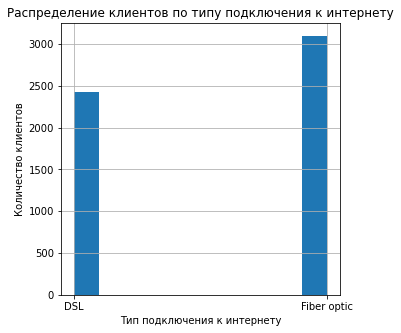

In [9]:
df_internet['InternetService'].hist(figsize=(5,5))
plt.title(f'Распределение клиентов по типу подключения к интернету')
plt.ylabel('Количество клиентов')
plt.xlabel('Тип подключения к интернету')
plt.show()

***Таблица phone***

In [10]:
info(df_phone)

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes
7892-POOKP,Yes
6388-TABGU,No
9763-GRSKD,No
7469-LKBCI,No


Информация о данных таблицы

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


None

Статистическая информация о таблице


,MultipleLines
count,6361
unique,2
top,No
freq,3390


Количество уникальных пользователей


6361

Количество уникальных значений


MultipleLines    2
dtype: int64

Количество явных дубликатов в таблице


6359

Количество явных дубликатов кода клиента в таблице


0

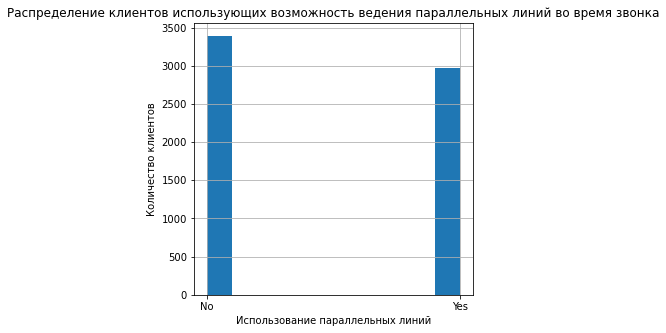

In [11]:
df_phone['MultipleLines'].hist(figsize=(5,5))
plt.title(f'Распределение клиентов использующих возможность ведения параллельных линий во время звонка')
plt.ylabel('Количество клиентов')
plt.xlabel('Использование параллельных линий')
plt.show()

После рассмотрения данных в таблицах, можно сделать следующий вывод:
- размеры таблиц отличаются
- в таблице `contract` наблюдается несоответствие типов данных;
- в таблицах отсутствуют пропуски;
- явные дубликаты по коду клиентов отсутствуют;
- дата окончания контракта для ряда пользователей отсутствует, что говорит о том, что контракт еще действует;
- даты начала и окончания контракта указаны с периодичностью в месяц;
- пользователи чаще используют оптоволокно для подключения к интернету и реже возможность ведения параллельных линий во время звонка.

## План

1. Провести предобработку данных и подготовить таблицу:
 - превести типы данных в соответствие;
 - превести наименование колонок в соответствии с PEP8;
 - проверить таблицы на наличие ошибок и аномалий.
 

2. Подготовить таблицу:
 - объединить таблицы;
 - провести анализ таблицы и обработать пропуски в объединенной таблице;
 - создать целевой признак по колонке `EndDate`, для ушедших пользователей указать - 1, для оставшихся - 0;
 - добавить/удалить признаки;
 - оценить корреляцию признаков;
 - выполнить отбор признаков;
 - оценить соотношение классов целевого признака.
 

3. Обучение моделей:
 - произвести кодировку категориальных признаков;
 - обучить не менее двух моделей с подбором параметром и использования кросс-валидации;
 - выбрать лучшую модель и оценить ее на тестовой выборке (для оценки качества использовать метрики ROC-AUC и Accuracy).
 

4. Подготовить отчет.

## Предобработка данных

Приведу название колонок к нижнему регистру и название колонок приведу в соответствии с PEP8

In [12]:
df_contract = df_contract.rename(columns={'BeginDate': 'Begin_Date',
                                          'EndDate': 'End_Date',
                                          'PaperlessBilling': 'Paperless_Billin',
                                          'PaymentMethod': 'Payment_Method',
                                          'MonthlyCharges': 'Monthly_Charges',
                                          'TotalCharges': 'Total_Charges'})

df_personal = df_personal.rename(columns={'SeniorCitizen': 'Senior_Citizen'})

df_internet = df_internet.rename(columns={'InternetService': 'Internet_Service',
                                          'OnlineSecurity': 'Online_Security',
                                          'OnlineBackup': 'Online_Backup',
                                          'DeviceProtection': 'Device_Protection',
                                          'TechSupport': 'Tech_Support',
                                          'StreamingTV': 'Streaming_TV',
                                          'StreamingMovies': 'Streaming_Movies'})

df_phone = df_phone.rename(columns={'MultipleLines': 'Multiple_Lines'})

In [13]:
df = [df_contract, df_personal, df_internet, df_phone]
for col in df:
    col = pd.DataFrame(col)
    col.columns = col.columns.str.lower()

In [14]:
for name_col in df:
    print(name_col.columns)

Index(['begin_date', 'end_date', 'type', 'paperless_billin', 'payment_method',
       'monthly_charges', 'total_charges'],
      dtype='object')
Index(['gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')
Index(['internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')
Index(['multiple_lines'], dtype='object')


Теперь необходимо привести типы данных колонок в соответствие

**Изменения типа данных**

Изменю тип данных в колонке `end_date` на `datetime`, предварительно изменив значение `No` на дату окончания выгрузки данных - 2020-02-01, так как `No` говорит о том, что дата окончания пользования услуг не наступила. Посмотрю на максимаальную дату в колонке `end_date`.

In [15]:
max_date = df_contract['end_date'].loc[df_contract['end_date'] != 'No'].max()
print('Максимальная указанная дата ухода клиента:', max_date)

Максимальная указанная дата ухода клиента: 2020-01-01


Отлично, максимальная дата ухода 2020-01-01, значит значение `No` можно точно менять на дату окончания выгрузки данных - 2020-02-01

In [16]:
df_contract.loc[df_contract['end_date'] == 'No', 'end_date'] = END_DATE
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'])

В колонке `total_charges` при изменении типа данных на float появляется ошибка, что в данных содержится пробел. Посмотрю на количество таких значений.

In [17]:
df_contract.loc[df_contract['total_charges'] == ' ']

,begin_date,end_date,type,paperless_billin,payment_method,monthly_charges,total_charges
customerID,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,


Из выведеного среза можно заметить, что пропуски в колонке `total_charges`, связаны с тем, что это новые пользователи и у них еще нет потраченных сумм на услуги. Заменю пробелы на 0.

In [18]:
df_contract.loc[df_contract['total_charges'] == ' ', 'total_charges'] = 0

In [19]:
df_contract['total_charges'] = df_contract['total_charges'].astype('float64')

In [20]:
df_contract.dtypes

begin_date          datetime64[ns]
end_date            datetime64[ns]
type                        object
paperless_billin            object
payment_method              object
monthly_charges            float64
total_charges              float64
dtype: object

**Объединение таблиц**

In [21]:
full_df = df_contract.join([df_personal, df_internet, df_phone])

In [22]:
full_df.head()

,begin_date,end_date,type,paperless_billin,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [23]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billin   7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   int64         
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   5517 non-null   object        
 12  online_security    5517 non-null   object        
 13  online_backup      5517 non-null   object        
 14

<div class="alert alert-success">
<h2> Комментарий тимлида (код) <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Соединили данные в единую таблицу - отлично, никакие пользователи не были потеряны.

In [24]:
full_df.isna().sum()

begin_date              0
end_date                0
type                    0
paperless_billin        0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

После объединения таблиц, в общей таблице образовались пропуски, так как размеры таблиц различались, заполню пропуски.

**Заполнение пропусков**

Пропуски в колонках находятся в категориальных признаках, что подразумевают то, что клиент не пользуется данными услугами, поэтому заполню пропуски в колонках значением `'No'`

In [25]:
col_fil = ['internet_service', 'online_security', 'online_backup', 'device_protection', 
           'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

In [26]:
full_df = full_df.fillna('No')

In [27]:
full_df[col_fil].isna().sum()

internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

In [28]:
for value in col_fil:
    print(value, full_df[value].unique())

internet_service ['DSL' 'Fiber optic' 'No']
online_security ['No' 'Yes']
online_backup ['Yes' 'No']
device_protection ['No' 'Yes']
tech_support ['No' 'Yes']
streaming_tv ['No' 'Yes']
streaming_movies ['No' 'Yes']
multiple_lines ['No' 'Yes']


**Создание признаков**

Создам признак с длительностью действия договора

In [29]:
full_df['contract_duration'] = (full_df['end_date'] - full_df['begin_date']).dt.days

Создаю целевой признак, 1 - клиент ушел, 0 - клиент остался

In [30]:
full_df['target'] = ((pd.Timestamp(END_DATE) - full_df['end_date']).dt.days > 0).astype(int)

In [31]:
full_df.head(10)

,begin_date,end_date,type,paperless_billin,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,contract_duration,target
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,...,DSL,No,Yes,No,No,No,No,No,31,0
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,...,DSL,Yes,No,Yes,No,No,No,No,1036,0
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,...,DSL,Yes,Yes,No,No,No,No,No,123,0
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,...,DSL,Yes,No,Yes,Yes,No,No,No,1371,0
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,...,Fiber optic,No,No,No,No,No,No,No,153,0
9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,No,...,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,337,0
1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,No,...,Fiber optic,No,Yes,No,No,Yes,No,Yes,671,0
6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,Female,0,No,...,DSL,Yes,No,No,No,No,No,No,306,0
7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,Yes,...,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,945,0


## Исследовательский анализ признаков

Рассмотрю распределения признаков

In [32]:
plot_features = ['type', 'paperless_billin', 'payment_method', 'gender', 'partner', 'senior_citizen', 'dependents',
                 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support',
                 'streaming_tv', 'streaming_movies', 'multiple_lines']

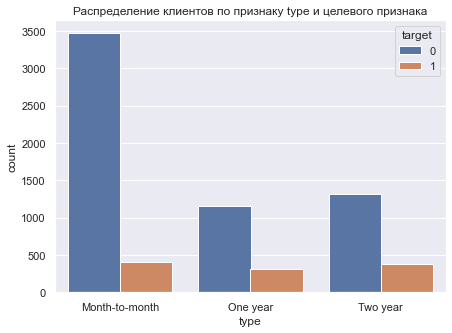

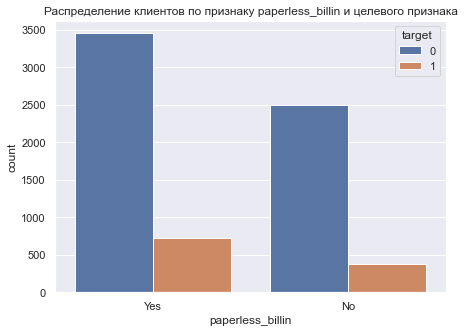

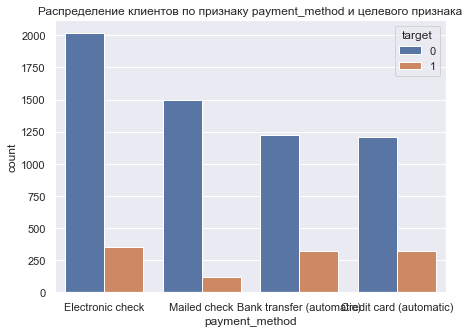

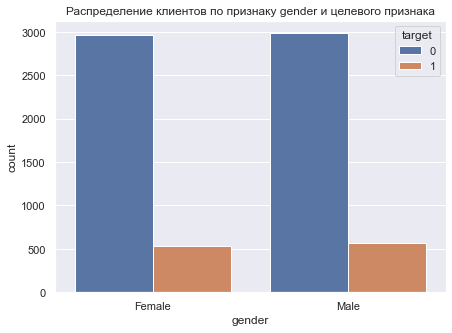

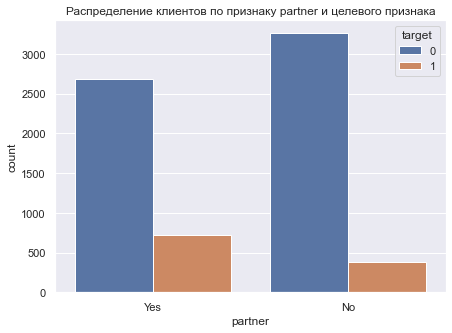

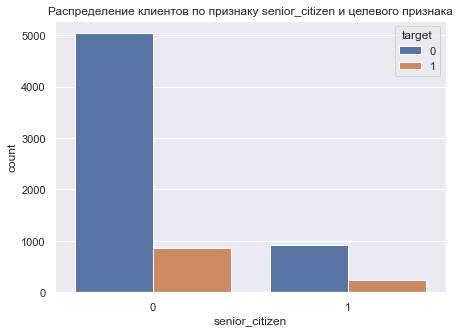

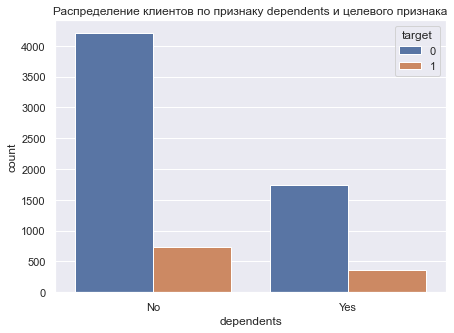

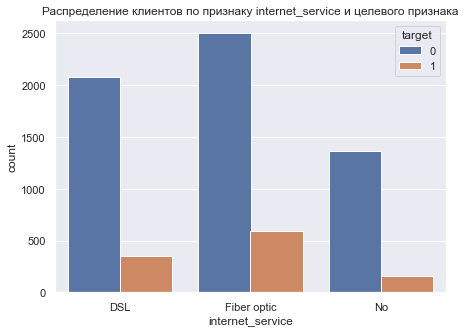

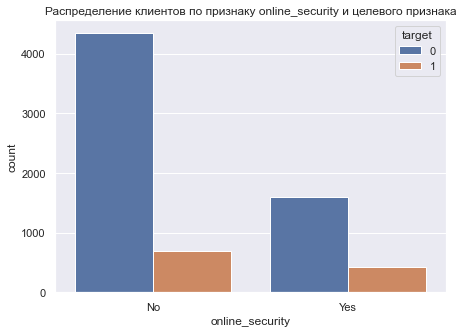

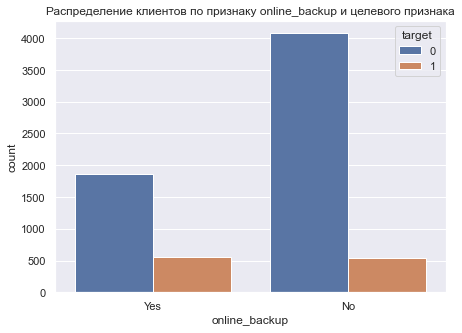

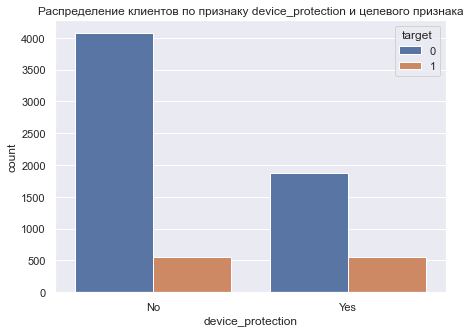

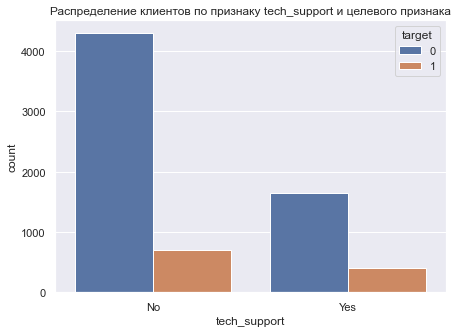

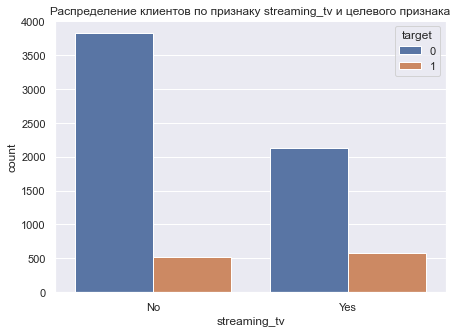

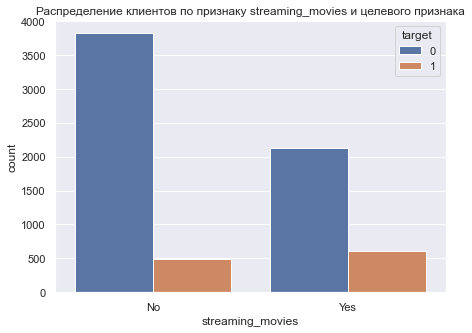

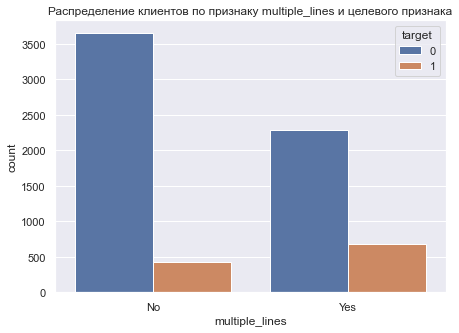

In [33]:
for i in plot_features:
    plt.figure(figsize=(7,5))
    sns.set()
    sns.countplot(full_df[i], hue = full_df['target'])
    plt.title(f'Распределение клиентов по признаку {full_df[i].name} и целевого признака')
    plt.show()

По графикам можно заметить, что:
 - клиенты больше всего предпочитают месячные договоры, но и доля ушедших клиентов с месячным договором меньше всего. Менее всего клиенты предпочитают годовые и двухлетние договоры и доля ушедших клиентов при данных договорах приблизительно одинаковая
 - чаще всего клиенты предпочитают электронные чеки
 - большинство клиентов предпочитают электронный способ оплаты, доля ушедших клиентов с автоматической оплатой значительно выше, чем без использования автоматической оплаты
 - признак отображающий пол клиентов никак не отображает зависимость оттока клиентов
 - клиенты имеющие супруга или супругу чаще закрывают договор
 - клиентов молодого поколения значительно выше, чем клиентов пенсионного возраста, но отток клиентов пенсионного возраста выше, чем у молодого поколения
 - клиенты с наличием иждевенцев чаще закрывают договор
 - тип подключения к интернету не влияет на отток клиентов
 - большинство клиентов не подключает дополнительные услуги - блокировки небезопасных сайтов, облачного хранилища, антивируса, выделенной линии технической поддержки, стримминогового телевидения каталог фильмов и возможность ведения параллельных линий во время звонка, но можно заметить, что отток клиентов значительно выше у клиентов использующих данные услуги.

Рассмотрю ежемесячные затраты клиентов на боксплоте при использовании услуг

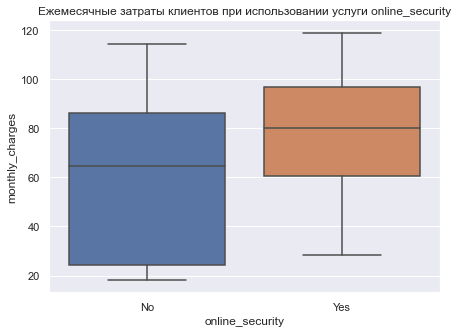

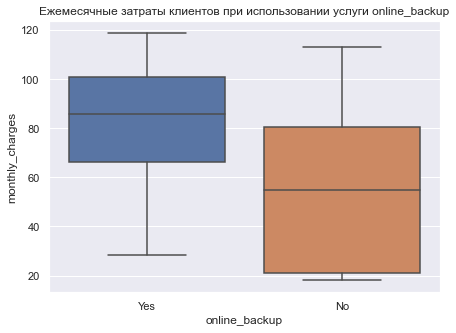

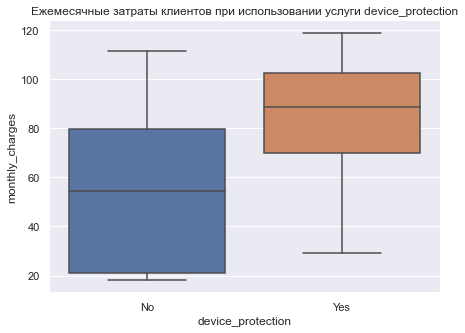

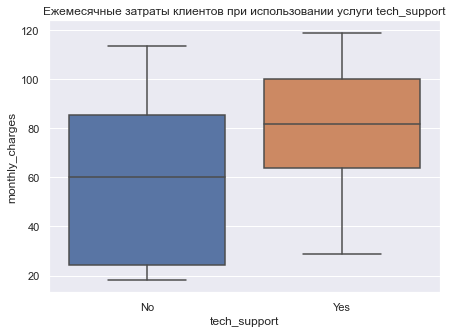

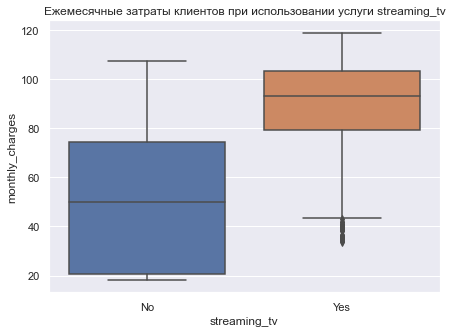

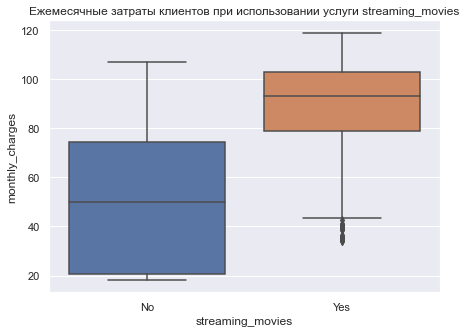

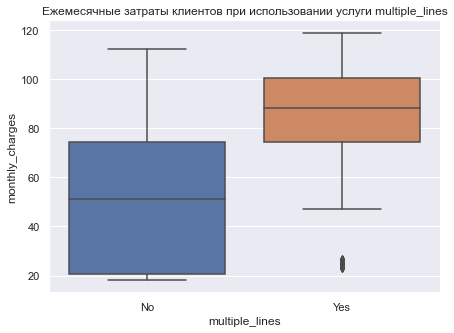

In [34]:
for i in plot_features[8:]:
    plt.figure(figsize=(7,5))
    sns.boxplot(x = i, y = 'monthly_charges', data = full_df)
    plt.title(f'Ежемесячные затраты клиентов при использовании услуги {full_df[i].name}')
    plt.show()

Глядя на "ящики с усами" стало понятно, почему такой большой отток клиентов у которых подключены дополнительные услуги, медиана ежемесячных затрат при подключенных услугах, практически в 2 раза выше, чем у клиентов, у которых не подключены дополнительные услуги.

Посмотрю теперь на продолжительность действия договора по признакам.

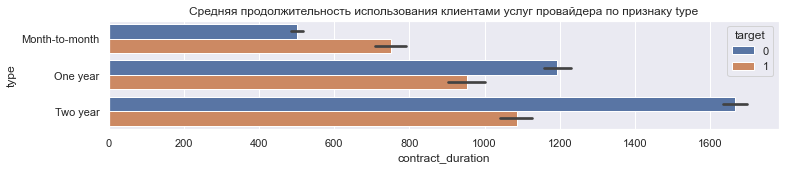

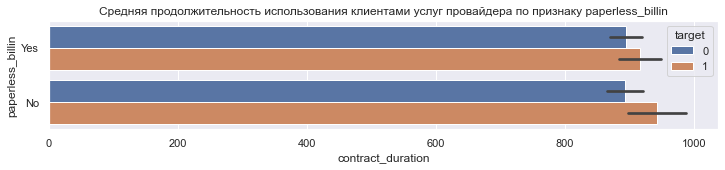

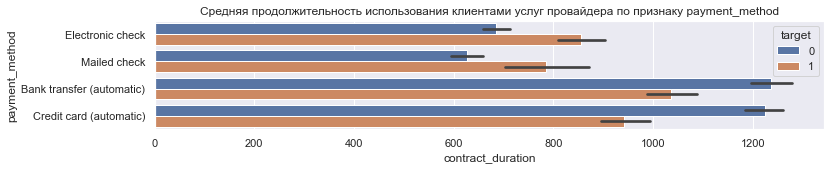

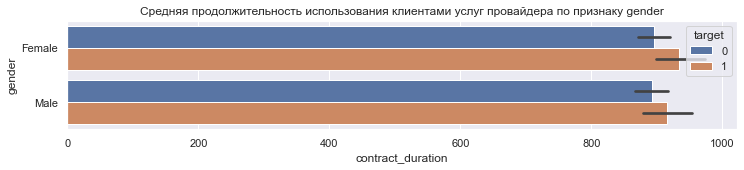

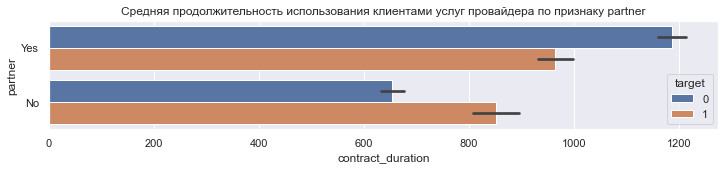

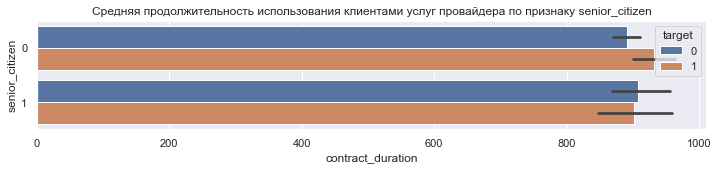

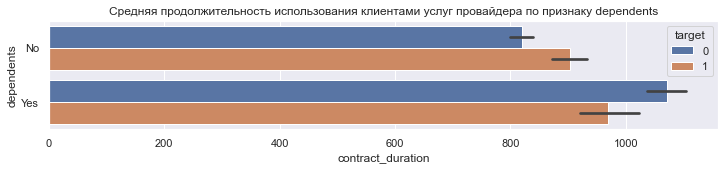

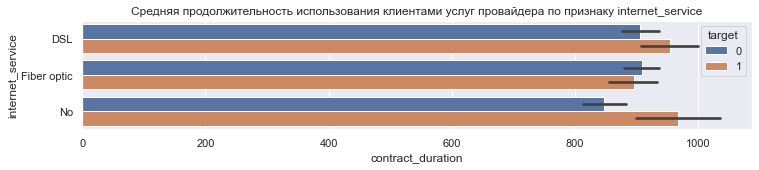

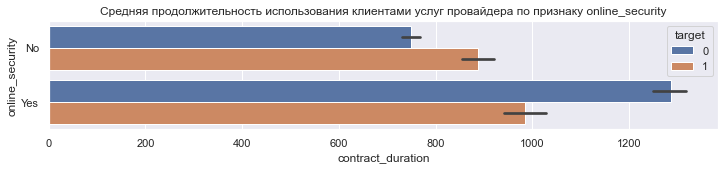

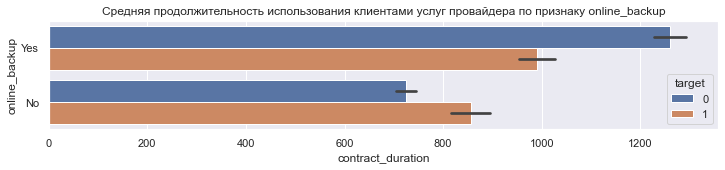

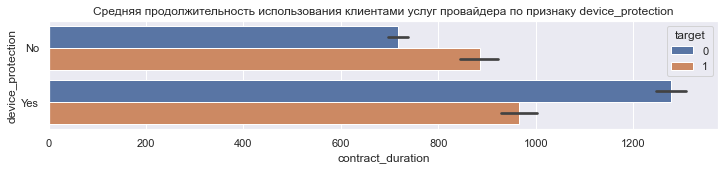

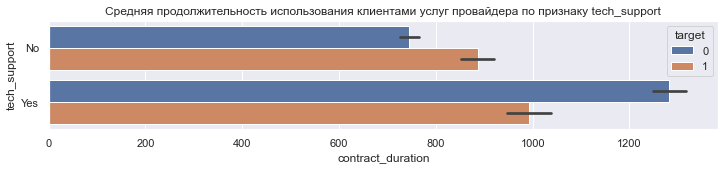

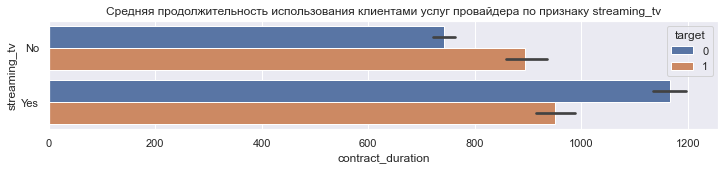

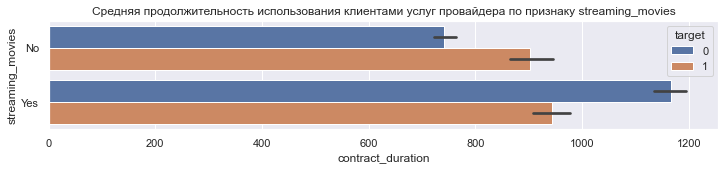

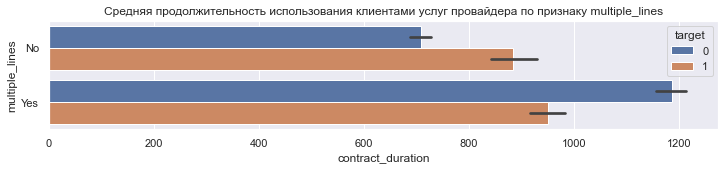

In [35]:
for i in plot_features: 
    plt.figure(figsize=(12,2))
    sns.barplot(x=full_df['contract_duration'], y=full_df[i].astype('str'),
                hue=full_df['target'])
    plt.title(f'Средняя продолжительность использования клиентами услуг провайдера по признаку {full_df[i].name}')
    plt.show()

Можно заметить, что срок использования месячных договоров самый короткий. А срок использования услуг у ушедших клиентов значительно меньше, чем у постоянных клиентов. Но при автоматическом списании оплаты за услуги, средний срок продолжительности использования клиентами услуг выше, чем при выставлении чека.

***Количественные признаки***

Построю гистограммы, боксплоты для количественных признаков и создам матрицу корреляции.

In [36]:
num_f = ['target', 'monthly_charges', 'total_charges', 'contract_duration']

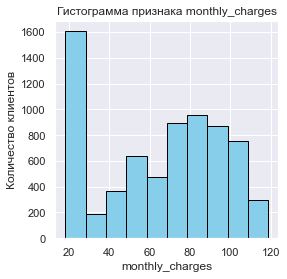

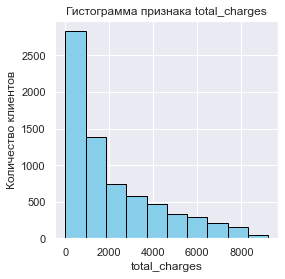

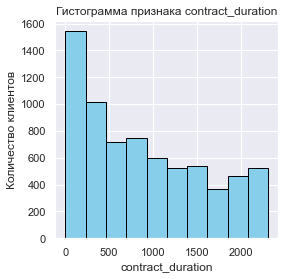

In [37]:
for i in num_f[1:]:
    plt.figure(figsize=(4,4))
    plt.hist(full_df[i], edgecolor = 'black', color  = 'skyblue')
    plt.title(f'Гистограмма признака {full_df[i].name}')
    plt.ylabel('Количество клиентов')
    plt.xlabel(full_df[i].name)
    plt.show()

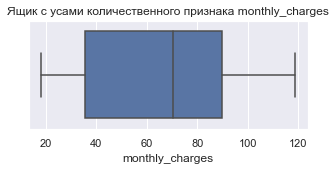

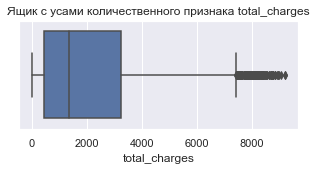

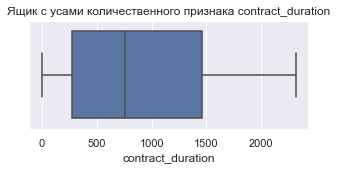

In [38]:
for i in num_f[1:]:
    plt.figure(figsize=(5,2))
    sns.boxplot(x = i, data = full_df)
    plt.title(f'Ящик с усами количественного признака {full_df[i].name}')
    plt.show()

Большинство клиентов ежемесячно тратит не больше 90 со средним сроком длительности контракта до 1500 дней. В признаке с общими тратами наблюдаются выбросы, скорее всего это постоянные долгосрочные клиенты с действующим контрактом на дату выгрузки данных, посмотрю на них.

In [39]:
full_df[full_df['total_charges'] > 7500]

,begin_date,end_date,type,paperless_billin,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,contract_duration,target
customerID,,,,,,,,,,,,,,,,,,,,,
9959-WOFKT,2014-03-01,2020-02-01,Two year,No,Bank transfer (automatic),106.70,8257.51,Male,0,No,...,Fiber optic,Yes,No,Yes,No,Yes,Yes,Yes,2163,0
5067-XJQFU,2014-08-01,2020-02-01,One year,Yes,Electronic check,108.45,7730.32,Male,1,Yes,...,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes,2010,0
5954-BDFSG,2014-02-01,2020-02-01,Two year,Yes,Credit card (automatic),107.50,7740.00,Female,0,No,...,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,2191,0
7255-SSFBC,2014-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),112.25,8324.46,Male,0,Yes,...,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes,2191,0
3520-FJGCV,2014-02-01,2020-02-01,Two year,Yes,Credit card (automatic),112.60,8755.78,Male,0,Yes,...,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2191,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3508-CFVZL,2014-03-01,2020-02-01,Two year,No,Mailed check,111.30,7902.30,Female,0,No,...,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2163,0
0530-IJVDB,2014-04-01,2020-02-01,Two year,Yes,Electronic check,114.60,8182.44,Male,0,No,...,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2132,0
8213-TAZPM,2014-05-01,2020-02-01,One year,Yes,Bank transfer (automatic),108.75,7728.86,Female,0,Yes,...,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes,2102,0


Да, действительно, выбросы отображают постоянных клиентов с действующим контрактом на дату выгрузки данных.

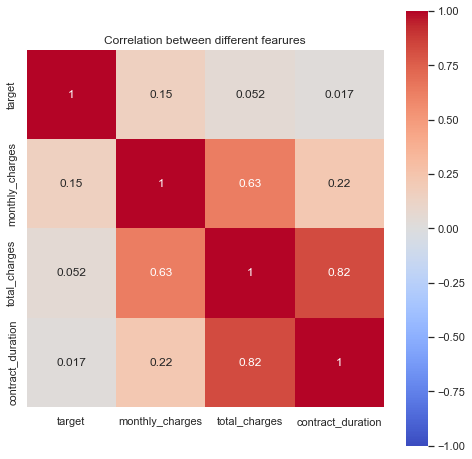

In [40]:
plt.figure(figsize=(8, 8))
sns.heatmap(full_df[num_f].corr(), vmin=-1, vmax=1, square=True,annot=True, cmap='coolwarm', center=0)

plt.title('Correlation between different fearures')
plt.show()

С целевым признаком в большей степени коррелирует сумма ежемесячной оплаты и естественно общая сумма трат зависит от срока использования услуг провайдера, так же высокая связь видна между ежемесячной суммой и общей суммой.

Построю тепловую карту матрицы корреляций с помощью библиотеки `phik`

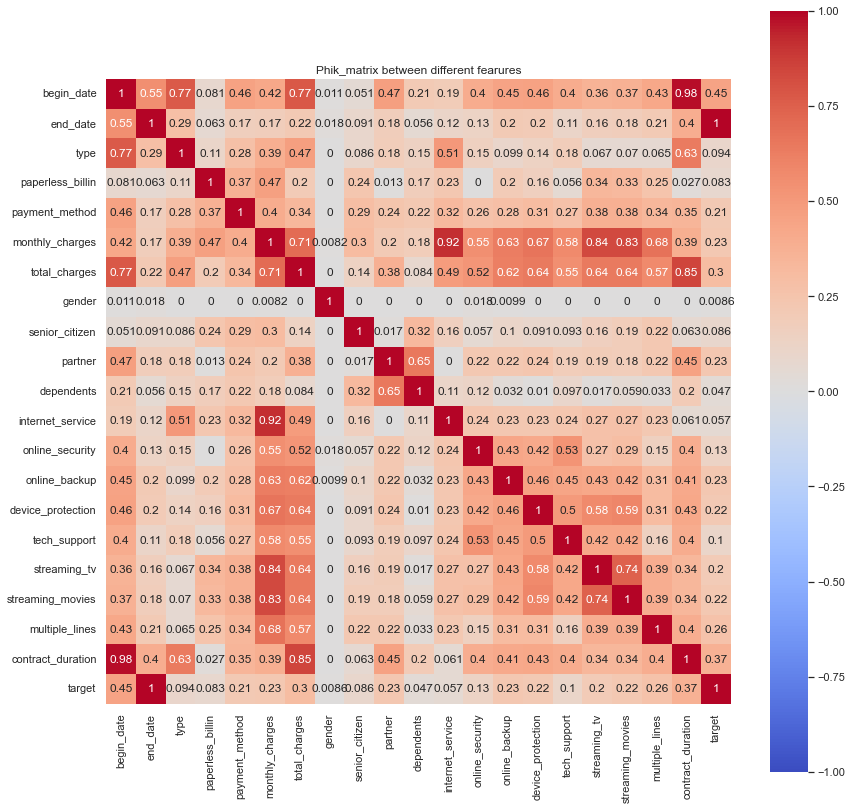

In [41]:
plt.figure(figsize=(14, 14))
sns.heatmap(full_df.phik_matrix(interval_cols=num_f), vmin=-1, vmax=1, square=True,annot=True, cmap='coolwarm', center=0)
plt.title('Phik_matrix between different fearures')
plt.show()

Посмотрю на эту же тепловую карту, но обозначу границу коэффициента корреляции >=0.8

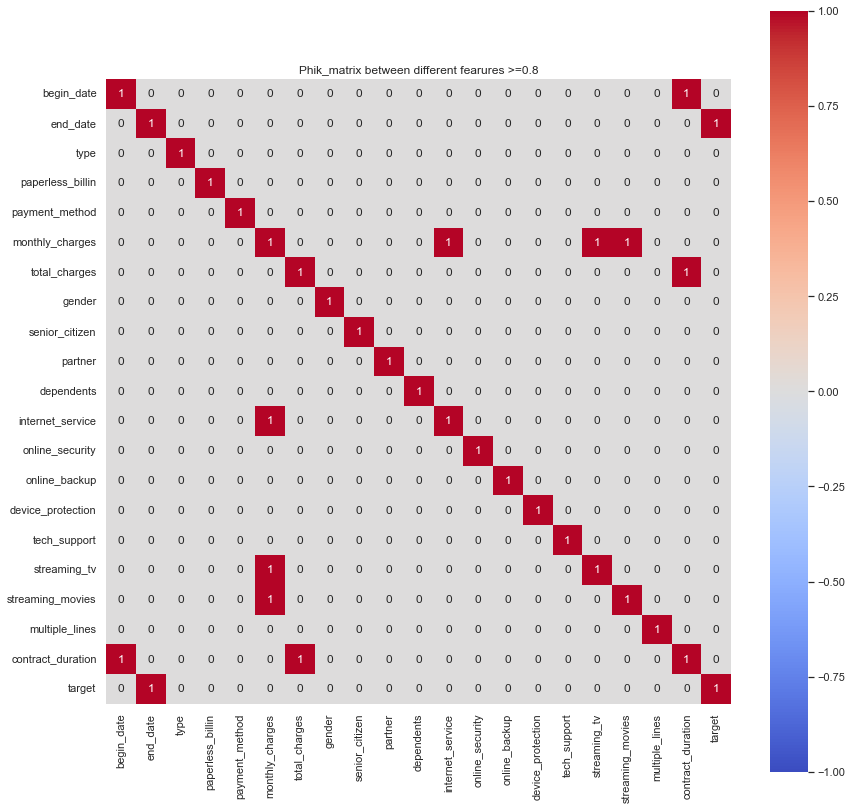

In [42]:
plt.figure(figsize=(14, 14))
sns.heatmap(full_df.phik_matrix(interval_cols=num_f)>=0.8, vmin=-1, vmax=1, square=True,annot=True, cmap='coolwarm', center=0)
plt.title('Phik_matrix between different fearures >=0.8')
plt.show()

По тепловой карте заметно, что дата начала контракта коррелирует с длительностью контракта, это логично, ведь длительность контракта была найдена с помощью начальной даты. Похожая ситуация и с датой окончания контракта, только он коррелирует с целевым признаком, а целевой признак был найден с помощью колонки `end_date`. Сумма ежемесячной оплаты сильно коррелирует с дополнительными услугами, ведь от них зависит сумма ежемесячной оплаты. Так же заметно, что признак `total_charges` мультиколлинеарен по отношению к `contract_duration`.

**Баланс классов**

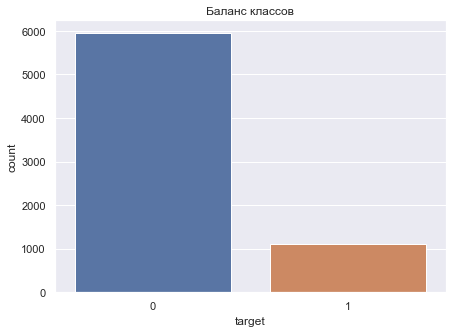

In [43]:
plt.figure(figsize=(7,5))
sns.countplot(full_df['target'])
plt.title('Баланс классов')
plt.show()

В целевом признаке наблюдается дисбаланс классов, необходимо будет поработать с дисбалансом. 

## Подготовка признаков

Удалю неинформативные признаки, они нам не понадобятся при обучении. Гендер не на что не влияет, общая сумма потраченных денег  и ежемесячная сумма оплаты - мультиколлинеарны, а даты заключения и окончания договора нам не нужны, т.к. целевой признак и продолжительность договора для каждого клиента посчитаны.

In [44]:
full_df.drop(['begin_date', 'end_date', 'gender', 'total_charges', 'monthly_charges'], axis=1, inplace=True)

In [45]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   type               7043 non-null   object
 1   paperless_billin   7043 non-null   object
 2   payment_method     7043 non-null   object
 3   senior_citizen     7043 non-null   int64 
 4   partner            7043 non-null   object
 5   dependents         7043 non-null   object
 6   internet_service   7043 non-null   object
 7   online_security    7043 non-null   object
 8   online_backup      7043 non-null   object
 9   device_protection  7043 non-null   object
 10  tech_support       7043 non-null   object
 11  streaming_tv       7043 non-null   object
 12  streaming_movies   7043 non-null   object
 13  multiple_lines     7043 non-null   object
 14  contract_duration  7043 non-null   int64 
 15  target             7043 non-null   int32 
dtypes: int32(1), int64(2), object(13

In [46]:
full_df.head()

,type,paperless_billin,payment_method,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,contract_duration,target
customerID,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,0,Yes,No,DSL,No,Yes,No,No,No,No,No,31,0
5575-GNVDE,One year,No,Mailed check,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036,0
3668-QPYBK,Month-to-month,Yes,Mailed check,0,No,No,DSL,Yes,Yes,No,No,No,No,No,123,0
7795-CFOCW,One year,No,Bank transfer (automatic),0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1371,0
9237-HQITU,Month-to-month,Yes,Electronic check,0,No,No,Fiber optic,No,No,No,No,No,No,No,153,0


**Вывод:**

- Проведена предобработка данных
- Объединены таблицы и заполнены пропуски
- Созданы новые признаки и целевой признак
- Проведен анализ признаков
- Удалены неинформативные признаки

# Создание и обучение моделей

## Подготовка признаков для обучения

Выделю категориальные и численные признаки

In [47]:
categorial = ['type', 'paperless_billin', 'payment_method', 'partner', 'dependents',
                 'internet_service', 'online_security', 'online_backup', 'device_protection',
               'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']
numeric = ['contract_duration']

In [48]:
full_df.dtypes

type                 object
paperless_billin     object
payment_method       object
senior_citizen        int64
partner              object
dependents           object
internet_service     object
online_security      object
online_backup        object
device_protection    object
tech_support         object
streaming_tv         object
streaming_movies     object
multiple_lines       object
contract_duration     int64
target                int32
dtype: object

Разделю таблицу на признаки и целевой признак

In [49]:
features = full_df.drop('target', axis=1)
target = full_df['target']
display(features.shape)
display(target.shape)

(7043, 15)

(7043,)

Разделю таблицу на обучающую и тестовую выборки и закодирую категориальные признаки

In [50]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

In [51]:
display(features_train.shape)
display(features_test.shape)
display(target_train.shape)
display(target_test.shape)

(5282, 15)

(1761, 15)

(5282,)

(1761,)

Модель LightGBM принимает категориальные признаки в виде типа данных `category`. Поэтому для данной модели изменю тип данных категориальных признаков.

In [52]:
features_train_lgbm = features_train
features_train_lgbm[categorial] = features_train_lgbm[categorial].astype('category')
features_test_lgbm = features_test
features_test_lgbm[categorial] = features_test_lgbm[categorial].astype('category')

In [53]:
features_train_lgbm.dtypes

type                 category
paperless_billin     category
payment_method       category
senior_citizen          int64
partner              category
dependents           category
internet_service     category
online_security      category
online_backup        category
device_protection    category
tech_support         category
streaming_tv         category
streaming_movies     category
multiple_lines       category
contract_duration       int64
dtype: object

Создам функцию для обучения моделей логистической регрессии, дерева решений и случайного леса

In [54]:
transformer = make_column_transformer(
    (StandardScaler(), numeric),
    (OneHotEncoder(drop='first', handle_unknown='ignore'), categorial),
    remainder='passthrough')

In [55]:
def model_training(model, params):
    pipeline = Pipeline([
        ('transformer', transformer),
        ('model', model)])
    random_model = RandomizedSearchCV(pipeline, param_distributions = params,
                cv=5, scoring = ['roc_auc', 'accuracy'], refit = 'roc_auc', n_jobs = -1,
                                      random_state = RANDOM_STATE, verbose=False)
    f = random_model.fit(features_train, target_train)
    best_model = f.best_estimator_
    print('Метрика ROC-AUC: ', random_model.best_score_)
    print('Метрика Accuracy: ', random_model.cv_results_['mean_test_accuracy'][random_model.best_index_])
    print('Best params: ', random_model.best_params_)
    
    return f

## Обучение моделей

**LogisticRegression**

In [56]:
%%time
model_lr = LogisticRegression(random_state = RANDOM_STATE)
param_lr = {'model__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'model__max_iter': [500, 1000], 'model__C': [1, 5, 10, 20, 50], 'model__class_weight': ['balanced']}

model_lr_f = model_training(model_lr, param_lr)

Метрика ROC-AUC:  0.7487648899305521
Метрика Accuracy:  0.6904589891344858
Best params:  {'model__penalty': 'l2', 'model__max_iter': 1000, 'model__class_weight': 'balanced', 'model__C': 1}
CPU times: total: 656 ms
Wall time: 2.03 s


**DecisionTreeClassifier**

In [57]:
%%time
model_dtc = DecisionTreeClassifier(random_state=RANDOM_STATE)
param_dtc = {'model__max_depth': [None] + [i for i in range(2, 11)],
             'model__criterion':['gini','entropy'],
             'model__class_weight': ['balanced']}

model_dtc_f = model_training(model_dtc, param_dtc)

Метрика ROC-AUC:  0.7747215701006027
Метрика Accuracy:  0.7006776611909061
Best params:  {'model__max_depth': 6, 'model__criterion': 'entropy', 'model__class_weight': 'balanced'}
CPU times: total: 656 ms
Wall time: 1.96 s


**RandomForestClassifier**

In [58]:
%%time
model_rfc = RandomForestClassifier(random_state=RANDOM_STATE)
param_rfc = {'model__max_depth': [None] + [i for i in range(2, 11)],
            'model__n_estimators': [50, 150, 250, 350],
            'model__min_samples_split': [5, 10, 20],
            'model__class_weight': ['balanced'],
            'model__criterion':['gini','entropy']}

model_rfc_f = model_training(model_rfc, param_rfc)

Метрика ROC-AUC:  0.8157246707743738
Метрика Accuracy:  0.7650463361142169
Best params:  {'model__n_estimators': 250, 'model__min_samples_split': 10, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
CPU times: total: 1.45 s
Wall time: 15.7 s


**CatBoostClassifier**

In [59]:
scaler_c = StandardScaler()
features_train[numeric] = scaler_c.fit_transform(features_train[numeric]) 
features_test[numeric] = scaler_c.transform(features_test[numeric])

In [60]:
%%time

cbc_model = CatBoostClassifier(random_state=RANDOM_STATE, logging_level='Silent', 
                                 cat_features=categorial)
pipeline = Pipeline([('model', cbc_model)])

cbc_params = {'model__iterations': [50, 500],
             'model__depth': [None] + [i for i in range(2, 11)],
             'model__learning_rate': [0.1, 0.25],
             'model__auto_class_weights' : ['Balanced']}

random_model_cbc = RandomizedSearchCV(pipeline, param_distributions = cbc_params, 
                                  cv=5, scoring = ['roc_auc', 'accuracy'], refit = 'roc_auc', n_jobs = -1,
                                  random_state = RANDOM_STATE, verbose=False)
random_model_cbc_f = random_model_cbc.fit(features_train, target_train)
print('Метрика ROC-AUC: ', random_model_cbc_f.best_score_)
print('Метрика Accuracy: ', random_model_cbc_f.cv_results_['mean_test_accuracy'][random_model_cbc_f.best_index_])
print('Best params: ', random_model_cbc_f.best_params_)

Метрика ROC-AUC:  0.9248565501465293
Метрика Accuracy:  0.883946489492847
Best params:  {'model__learning_rate': 0.25, 'model__iterations': 500, 'model__depth': 3, 'model__auto_class_weights': 'Balanced'}
CPU times: total: 18 s
Wall time: 4min 52s


**LGBMClassifier**

In [61]:
scaler = StandardScaler()
features_train_lgbm[numeric] = scaler.fit_transform(features_train_lgbm[numeric]) 
features_test_lgbm[numeric] = scaler.transform(features_test_lgbm[numeric])

In [62]:
%%time

model_lgbm = LGBMClassifier(random_state=RANDOM_STATE)

pipeline = Pipeline([('model', model_lgbm)])

lgbm_params = {'model__num_iterations': [50, 500, 1000],
              'model__max_depth': [None] + [i for i in range(2, 11)],
              'model__class_weight': ['balanced'],
              'model__learning_rate': [0.1, 0.25, 0.4],
              'model__num_leaves': [5, 10, 15, 50]}

random_model_lgbm = RandomizedSearchCV(pipeline, param_distributions = lgbm_params, 
                                  cv=5, scoring = ['roc_auc', 'accuracy'], refit = 'roc_auc', n_jobs = -1,
                                  random_state = RANDOM_STATE, verbose=False)
random_model_lgbm.fit(features_train_lgbm, target_train)
print('Метрика ROC-AUC: ', random_model_lgbm.best_score_)
print('Метрика Accuracy: ', random_model_lgbm.cv_results_['mean_test_accuracy'][random_model_lgbm.best_index_])
print('Best params: ', random_model_lgbm.best_params_)

Метрика ROC-AUC:  0.9146242349170869
Метрика Accuracy:  0.8847062154181359
Best params:  {'model__num_leaves': 5, 'model__num_iterations': 1000, 'model__max_depth': 4, 'model__learning_rate': 0.1, 'model__class_weight': 'balanced'}
CPU times: total: 2 s
Wall time: 17.3 s


Отображу результаты обучения в таблице.

In [63]:
model = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'CatBoostClassifier', 'LGBMClassifier']

In [64]:
results = pd.DataFrame({'ROC-AUC' : [model_lr_f.best_score_, model_dtc_f.best_score_, model_rfc_f.best_score_, 
                                     random_model_cbc_f.best_score_, random_model_lgbm.best_score_],
                        'Accuracy' : [model_lr_f.cv_results_['mean_test_accuracy'][model_lr_f.best_index_],
                                      model_dtc_f.cv_results_['mean_test_accuracy'][model_dtc_f.best_index_],
                                       model_rfc_f.cv_results_['mean_test_accuracy'][model_rfc_f.best_index_],
                                        random_model_cbc_f.cv_results_['mean_test_accuracy'][random_model_cbc_f.best_index_],
                                         random_model_lgbm.cv_results_['mean_test_accuracy'][random_model_lgbm.best_index_]]},
                       index=model).sort_values(by='ROC-AUC', ascending=False)
results

,ROC-AUC,Accuracy
CatBoostClassifier,0.924857,0.883946
LGBMClassifier,0.914624,0.884706
RandomForestClassifier,0.815725,0.765046
DecisionTreeClassifier,0.774722,0.700678
LogisticRegression,0.748765,0.690459


## Проверка лучшей модели

По результатам обучения, лучше всего себя показала модель `CatBoostClassifier`, построю диаграмму значимости ее признаков.

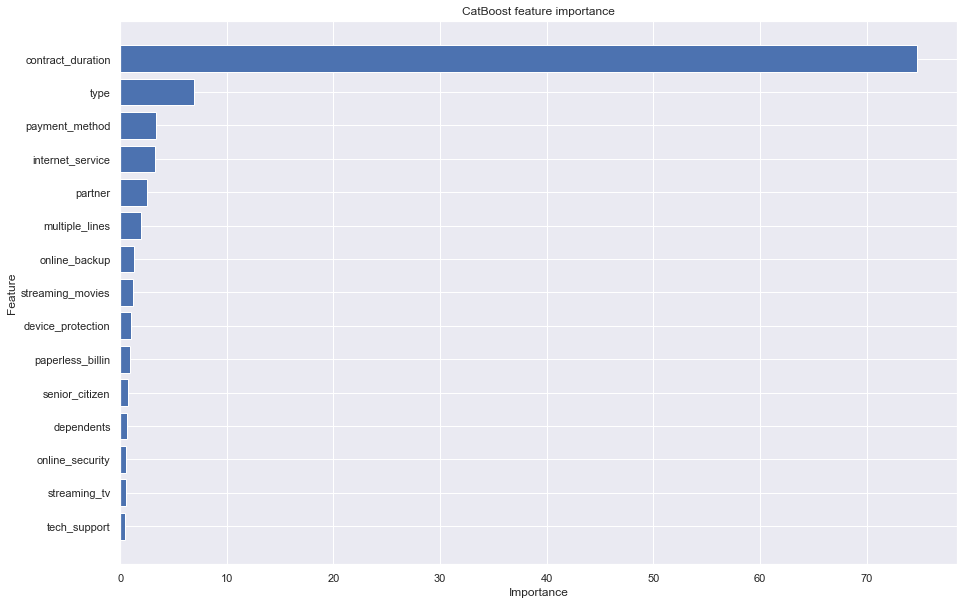

In [65]:
feature_transformer = random_model_cbc_f.best_estimator_.named_steps['model'].feature_names_
importances = random_model_cbc_f.best_estimator_._final_estimator.feature_importances_
sorted_idx = np.argsort(importances)
fig = plt.figure(figsize=(15, 10))
plt.barh(range(len(sorted_idx)), importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(feature_transformer)[sorted_idx])
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.title('CatBoost feature importance')
plt.show()

Самым значимым признаком является созданный признак - длительность контракта.

Теперь проверю данную модель на тестовой выборке, чтобы убедиться в качестве модели.

TEST ROC-AUC 0.9406200518858923
TEST Accuracy 0.871663827370812


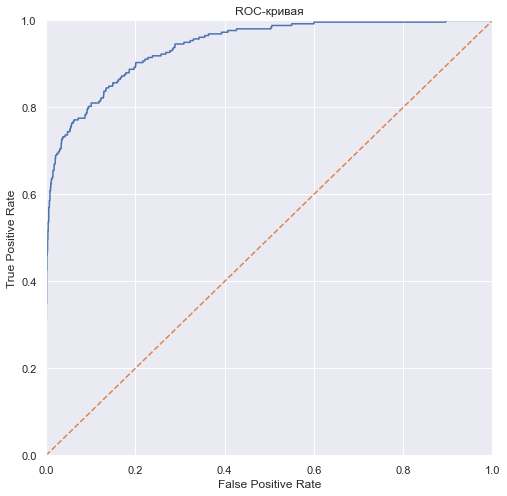

In [66]:
prediction = random_model_cbc_f.predict_proba(features_test)[:,1]
pred_accuracy = random_model_cbc_f.predict(features_test)
print('TEST ROC-AUC', roc_auc_score(target_test, prediction))
print('TEST Accuracy', accuracy_score(target_test, pred_accuracy))

fpr, tpr, thresholds = roc_curve(target_test, prediction)
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

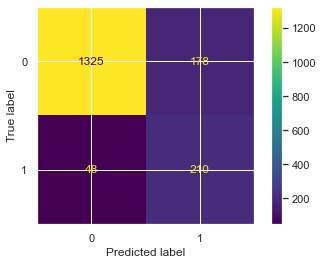

In [67]:
plot_confusion_matrix(estimator=random_model_cbc.best_estimator_, y_true = target_test, X = features_test);

Лучшая модель показала себя хорошо на тестовой выборке ROC-AUC = 0.94, Accuracy = 0.87

**Вывод:**

В проекте была проведена следующая работа:

- произведена предобработка данных
- добавлены новые признаки с длительностью использования услуг провайдера и целевой бинарный признак с оттоком клиентов
- проведен анализ признаков
- рассмотрен баланс классов
- созданы и обучены модели машинного обучения для предсказания оттока клиентов
- выбрана лучшая модель


Рассмотрев несколько моделей для предсказания оотока клиентов, можно сказать, что лучше всего подходит модель CatBoostClassifier, она выигрывает по всем показателям среди рассмотренных моделей.

При проведении анализа, можно было заметить, что большинство клиентов уходят из-за высокой стоимости услуг. Наибольший отток наблюдаетсяя именно у клиентов использующих дополнительные услуги. Так же большой отток клиентов наблюдается у новых пользователей. Стоит учесть данный факт для предложения клиентам акций и специальных условий.

# Отчет

## Выполненные пункты плана

В исходном плане было запланировано выполнение следующих задач:

1. Провести предобработку данных и подготовить таблицу:
 - превести типы данных в соответствие;
 - превести наименование колонок в соответствии с PEP8;
 - проверить таблицы на наличие ошибок и аномалий.
 

2. Подготовить таблицу:
 - объединить таблицы;
 - провести анализ таблицы и обработать пропуски в объединенной таблице;
 - создать целевой признак по колонке `EndDate`, для ушедших пользователей указать - 1, для оставшихся - 0;
 - добавить/удалить признаки;
 - оценить корреляцию признаков;
 - выполнить отбор признаков;
 - оценить соотношение классов целевого признака.
 

3. Обучение моделей:
 - произвести кодировку категориальных признаков;
 - обучить не менее двух моделей с подбором параметром и использования кросс-валидации;
 - выбрать лучшую модель и оценить ее на тестовой выборке (для оценки качества использовать метрики ROC-AUC и Accuracy).
 

4. Подготовить отчет.

Все пункты плана были выполнены, дополнительно был добавлен анализ признаков.

Производилось обучение 5 моделей:
- LogisticRegression
- DecisionTreeClassifier
- RandomForestClassifier
- LGBMClassifier
- CatBoostClassifier

## Возникшие трудности

Возникали трудности при обучение бустинговых моделей, а именно, применение `make_column_transformer` для скалирования непрерывных признаков, при обучении модель либо выдавала ошибку, либо плохо показывала себя на тестовой выборке.

Так же была проблема с передачей категориальных признаков модели - CatBoostClassifier. Когда `make_column_transformer` преобразовывает численные признаки, он ставит их в начало массива, а остальные признаки в рядок за ними. Катбуст ругался, что он ожидает массив либо без категорий, либо с категориями, но с указанием, где какой столбец, а ему после `make_column_transformer` прилетал массив вперемешку с числами и строками, и он падал. Решение оказалось интересным, которое нашел тимлид проекта - Алексей Гриб, в `cat_features` вместо явных названий категорий передать индексы столбцов преобразованного make_column_transformerом массива, в которых содержатся категориальные признаки. Соответственно, cat_features = [i for i in range(2, 16)] здесь затем, потому что сначала идут два преобразованных непрерывных признака, а за ним в ряд (с индексам 2 по 15) идут категориальные переменные.

## Ключевые шаги в решении задачи

- Предобработка данных и заполнение пропусков.
- Добавление признаков, в датасете не был предоставлен целевой признак и созданный признак с длительностью контракта, оказался наиболее значимым.
- Исследовательский анализ, поскольку он помогает оценить взаимосвязь признаков и как эта взаимосвязь влияет на поведение клиентов.
- Обучение моделей с подбором параметров и используя кросс-валидацию, выбор лучшей модели. Проверка лучшей модели с помощью метрик ROC-AUC и Accuracy.

## Предобработка данных и признаки для обучения моделей

***Предобработка данных***

Перед отбором признаков для обучения модели, была проведена предобработка данных и создание дополнительного признака с длительностью контракта и целевого признака.

1. Приведение название колонок к нижнему регистру и наименование в соответствии с PEP8

```python

df_contract = df_contract.rename(columns={'BeginDate': 'Begin_Date',
                                          'EndDate': 'End_Date',
                                          'PaperlessBilling': 'Paperless_Billin',
                                          'PaymentMethod': 'Payment_Method',
                                          'MonthlyCharges': 'Monthly_Charges',
                                          'TotalCharges': 'Total_Charges'})

df_personal = df_personal.rename(columns={'SeniorCitizen': 'Senior_Citizen'})

df_internet = df_internet.rename(columns={'InternetService': 'Internet_Service',
                                          'OnlineSecurity': 'Online_Security',
                                          'OnlineBackup': 'Online_Backup',
                                          'DeviceProtection': 'Device_Protection',
                                          'TechSupport': 'Tech_Support',
                                          'StreamingTV': 'Streaming_TV',
                                          'StreamingMovies': 'Streaming_Movies'})

df_phone = df_phone.rename(columns={'MultipleLines': 'Multiple_Lines'})

df = [df_contract, df_personal, df_internet, df_phone]
for col in df:
    col = pd.DataFrame(col)
    col.columns = col.columns.str.lower()
    
    
```

2. Изменение типа данных в колонке `end_date` на `datetime` и `total_charges` на `float64`, предварительно изменив значение `No` на дату окончания выгрузки данных - `2020-02-01`, так как No говорит о том, что дата окончания пользования услуг не наступила. Так же рассмотрю максимальную дату в колонке `end_date`. А пробелы в колонке `total_charges` заменив на 0.

```python

END_DATE = '2020-02-01'

max_date = df_contract['end_date'].loc[df_contract['end_date'] != 'No'].max()
print('Максимальная указанная дата ухода клиента:', max_date)
Максимальная указанная дата ухода клиента: 2020-01-01

    
df_contract.loc[df_contract['end_date'] == 'No', 'end_date'] = END_DATE
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'])

df_contract.loc[df_contract['total_charges'] == ' ', 'total_charges'] = 0
df_contract['total_charges'] = df_contract['total_charges'].astype('float64')
```

3. Объединение таблиц и заполнение пропусков значением `No`. Так как пропуски обозначают, что клиент не пользуется данными услугами.

```python
full_df = df_contract.join([df_personal, df_internet, df_phone])
full_df = full_df.fillna('No')
```

***Создание признаков***

С помощью колонок `end_date` и `begin_date` создан признак с длительностью контракта клиента - `contract_duration` и целевой признак с оттоком клиентов - `target`.

```python
full_df['contract_duration'] = (full_df['end_date'] - full_df['begin_date']).dt.days
full_df['target'] = ((pd.Timestamp(END_DATE) - full_df['end_date']).dt.days > 0).astype(int)
```

***Рассмотрение признаков на мультиколлинеарность***

```python
plt.figure(figsize=(14, 14))
sns.heatmap(full_df.phik_matrix(interval_cols=num_f), vmin=-1, vmax=1, square=True,annot=True, cmap='coolwarm', center=0)
plt.title('Phik_matrix between different fearures')
plt.show()


plt.figure(figsize=(14, 14))
sns.heatmap(full_df.phik_matrix(interval_cols=num_f)>=0.8, vmin=-1, vmax=1, square=True,annot=True, cmap='coolwarm', center=0)
plt.title('Phik_matrix between different fearures >=0.8')
plt.show()

```

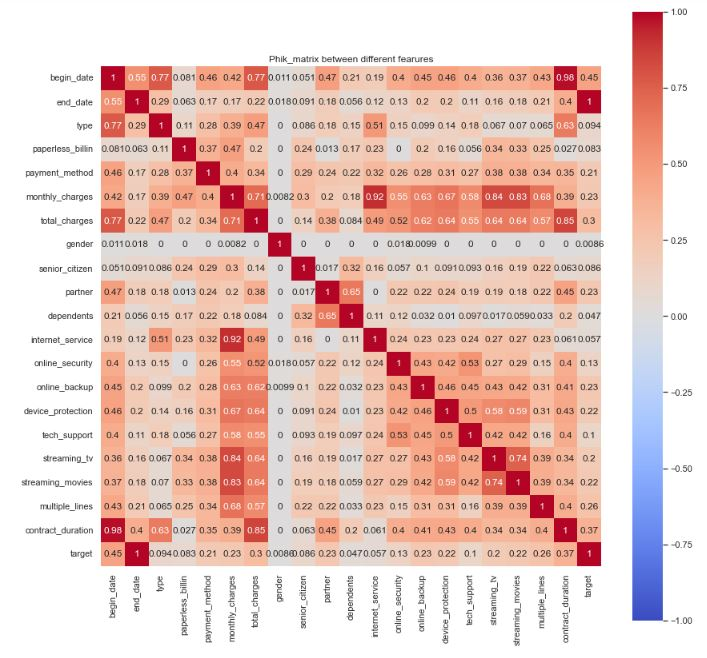

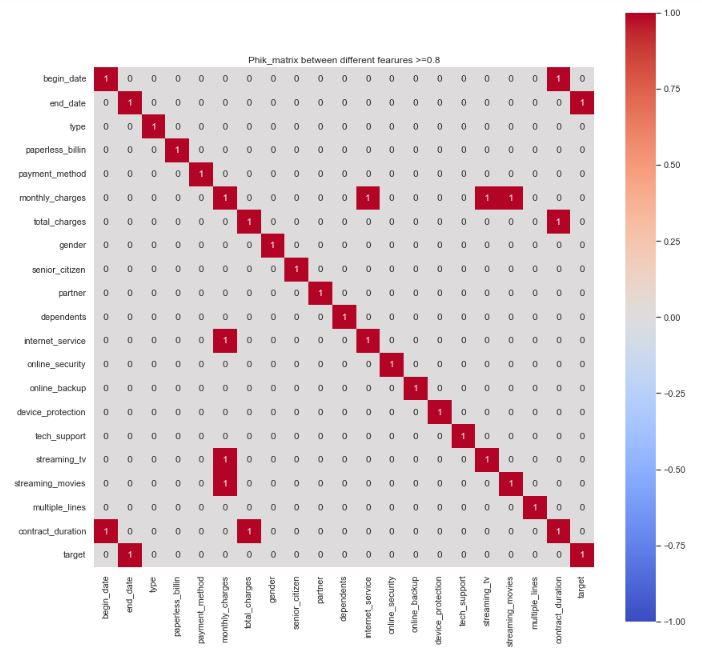

***Итоговый список признаков для обучения моделей***

После предобработки данных, объединения таблиц, заполнения пропусков и проверка признаков на мультиколлинеарность, были отобраны признаки для обучения моделей:

- `type` – тип оплаты: 
 - Month-to-month - ежемесячная оплата
 - One year - годовая оплата
 - Two year - двухлетний тип оплаты
- `paperless_billin` – безналичный расчет:
 - Yes - да
 - No - нет
- `payment_method` – способ оплаты
 - Electronic check - электронный чек
 - Mailed check - чек отправленный на почту
 - Bank transfer (automatic) - банковский перевод (автоматический)
 - Credit card (automatic) - оплата кредитной картой (автоматический)
- `dependents` – наличие иждивенцев
 - Yes - да
 - No - нет 
- `senior_citizen` – наличие пенсионного статуса по возрасту
 - 1 - да
 - 0 - нет
- `partner` – наличие супруга(и)
 - Yes - да
 - No - нет
- `internet_service` – тип подключения к интернету
 - DSL - подключение через телефонную линию 
 - Fiber optic - подключение через оптоволоконный кабель 
 - No - отсутствие подключения к интернету
- `online_security` – блокировка небезопасных сайтов
 - Yes - да
 - No - нет
- `online_backup` – облачное хранилище файлов для резервного копирования данных
 - Yes - да
 - No - нет
- `device_protection` – антивирус
 - Yes - да
 - No - нет
- `tech_support` – выделенная линия технической поддержки
 - Yes - да
 - No - нет
- `streaming_tv` – стриминговое телевидение
 - Yes - да
 - No - нет
- `streaming_movies` – каталог фильмов
 - Yes - да
 - No - нет
- `multiple_lines` – наличие возможности ведения параллельных линий во время звонка
 - Yes - да
 - No - нет
- `contract_duration` – длительность контракта клиента
- `target` – целевой признак, отображающий отток клиентов

## Обученные модели

При поиске лучшей модели, были обучены следующие модели:
- LogisticRegression
- DecisionTreeClassifier
- RandomForestClassifier
- LGBMClassifier
- CatBoostClassifier

Метрики качества на кросс-валидации исследованных моделей представлены в сводной таблице

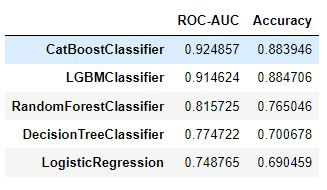

## Итоговая модель

Лучшей моделью признана модель - **CatBoostClassifier** с гиперпараметрами:

- `learning_rate` - 0.25
- `iterations` - 500
- `depth` - 3
- `auto_class_weights` - Balanced

Метрики качества обученной модели:
- `ROC-AUC` = 0.92, 
- `Accuracy` = 0.88

## Проверка итоговой модели на тестовой выборке

При проверке лучшей модели на тестовой выборке, итоговые метрики ROC-AUC и Accuracy показали следующие значения:
- `ROC-AUC` = 0.94, 
- `Accuracy` = 0.87

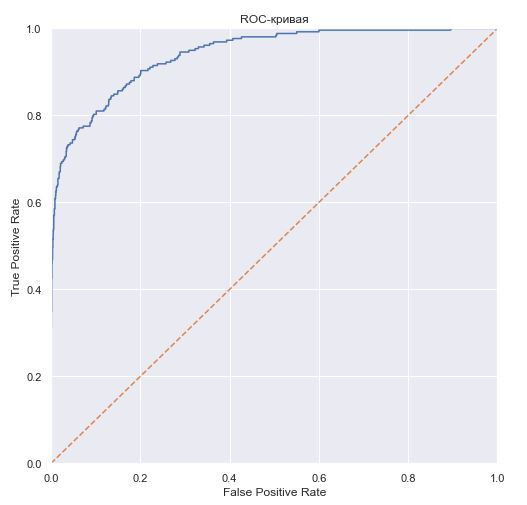

**График важности признаков**

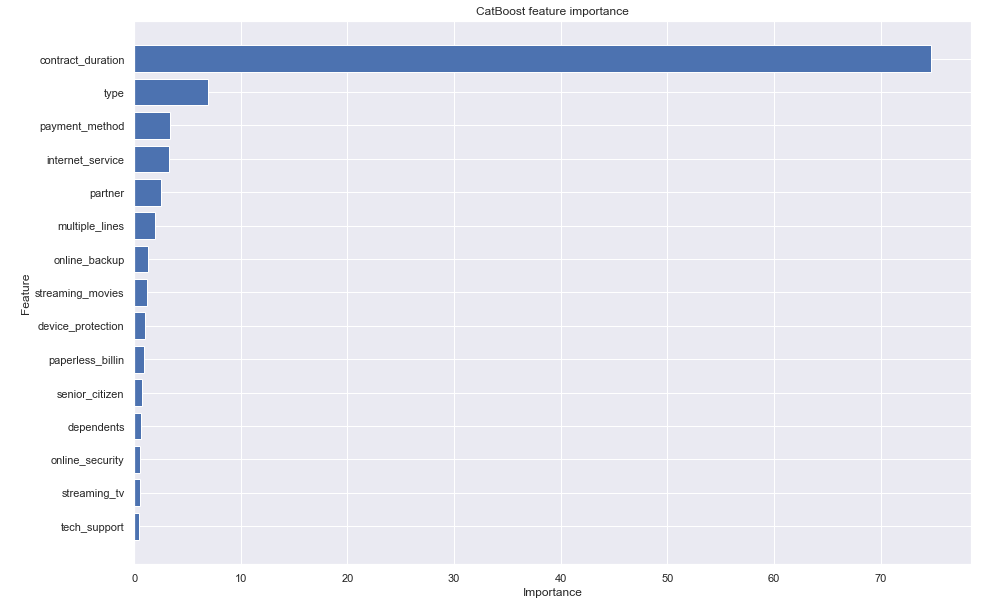

Самым значимым признаком является созданный признак - длительность контракта.

## Рекомендация заказчику

1. Замечено, что чаще уходят те клиенты, которые больше платят за месяц и используют интернет с дополнительными услугами: в следствии чего можно сделать вывод, что необходимо предоставлять скидку или дополнительные промокоды на использование интернета и дополнительных услуг потенциально уходящим клиентам.
2. Так же было замечено, что чаще уходят клиенты использующие интернет подключенный через телефонную линию, стоит оценить стоимость и качество данного типа подключения.

## Вывод

В ходе реализации проекта была проведена следующая работа:

- произведена предобработка данных
- добавлены новые признаки с длительностью использования услуг провайдера и целевой бинарный признак с оттоком клиентов
- проведен анализ признаков
- рассмотрен баланс классов
- созданы и обучены модели машинного обучения для предсказания оттока клиентов
- выбрана лучшая модель
- составлен отчет о выполнении проекта
- предоставлены рекомендации заказчику


Рассмотрев несколько моделей для предсказания оотока клиентов, можно сказать, что лучше всего подходит модель CatBoostClassifier, она выигрывает по всем показателям среди рассмотренных моделей.

При проведении анализа, можно было заметить, что большинство клиентов уходят из-за высокой стоимости услуг. Наибольший отток наблюдаетсяя именно у клиентов использующих дополнительные услуги. Так же большой отток клиентов наблюдается у новых пользователей. Стоит учесть данный факт для предложения клиентам акций и специальных условий.